In [1]:
# #download dataset
# !wget -N http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
# !tar -xzf VOCtrainval_06-Nov-2007.tar

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb
wandb.login()
wandb.init(project="Y-Data-DL-Week4-Super-Resolution")


W&B Run: https://app.wandb.ai/adcoh/Y-Data-DL-Week4-Super-Resolution/runs/1f2ltudr

In [2]:
class VOC2007Dataset(Dataset):
    """ 
    
    create Dataset class that takes input of PascalVOC dataset and creates sets of images of 
    sizes X - 72x72x3, y_mid – 144x144x3, y_large – 288x288x3 
    """
    
    def __init__(self, image_set='trainval', root=None, transform=None, sample_slice=None):
        """
        Args:
            image_set (str): one of 'train', 'trainval', or 'val', default "trainval"
            transform (callable, optional): Optional transform to be applied
                on a sample.
            sample_slice (list or tuple): a 2-value list or tuple indicating subset of files to be selected from the dataset
        """
        super(VOC2007Dataset).__init__()
        self.transform = transform
        
        if root is None:
            root = os.path.abspath(os.path.curdir)
        self.root = root
        valid_sets = ['train', 'trainval', 'val']
        assert (image_set in valid_sets), f"{image_set} not among the allowed values. Allowed values are {', '.join(valid_sets)}"
        
        base_dir = os.path.join('VOCdevkit', 'VOC2007')
        voc_root = os.path.join(self.root, base_dir)
        image_dir = os.path.join(voc_root, 'JPEGImages')
        splits_dir = os.path.join(voc_root, 'ImageSets/Main')
        split_f = os.path.join(splits_dir, image_set.rstrip('\n') + '.txt')
        
        with open(os.path.join(split_f), "r") as f:
            file_names = [x.strip() for x in f.readlines()]
        
        if sample_slice is None:
            sample_slice = (0, len(file_names))
        assert (sample_slice[-1] <= len(file_names)), f'sample_slice indices are out bounds. Maximum indices: {len(file_names)-1}'
        self.images = [os.path.join(image_dir, x + ".jpg") for x in file_names[sample_slice[0]:sample_slice[-1]]]
        
    
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is a dictionary of the XML tree.
        """
        img = cv2.imread(self.images[index], cv2.IMREAD_COLOR)
        img_large = cv2.resize(img, (288, 288))
        img_mid = cv2.resize(img, (144, 144))
        img_small = cv2.resize(img, (72, 72))

        if self.transform is not None:
            img_large = self.transform(img_large)
            img_mid = self.transform(img_mid)
            img_small = self.transform(img_small)

        return dict(y_large=img_large, y_mid=img_mid, X=img_small)
    
    
    def __len__(self):
        return len(self.images)


In [3]:
wandb.config.update(dict(batch_size=20, epochs=5, lr=0.01, no_cuda=True,
                                 seed=42, log_interval=10))        # Initialize config

In [4]:
config = wandb.config
use_cuda = not config.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {'num_workers': 2}

random.seed(config.seed)       # python random seed
torch.manual_seed(config.seed) # pytorch random seed
np.random.seed(config.seed) # numpy random seed

In [5]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = VOC2007Dataset(image_set='trainval', transform=transform, sample_slice=[0,100]) # training dataset
trainloader = DataLoader(trainset, batch_size=config.batch_size, shuffle=False, **kwargs)
testset = VOC2007Dataset(image_set='trainval', transform=transform, sample_slice=[-11, -1]) # validation dataset
testloader = DataLoader(testset, batch_size=config.batch_size, shuffle=False, **kwargs)

In [6]:
def show_images(image_dict):
    """Function to display images from three-image-tuple from VOC2007Dataset class
    Args:
        image_dict (dict): contains three different-sized image tensors of the same content 
    """
    f = plt.figure(figsize=(16, 6))
    n = 1
    for key, img in image_dict.items():
        ax = f.add_subplot(1, len(image_dict), n)
        img = img.detach().permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.title.set_text(key)
        n += 1
#     return fig

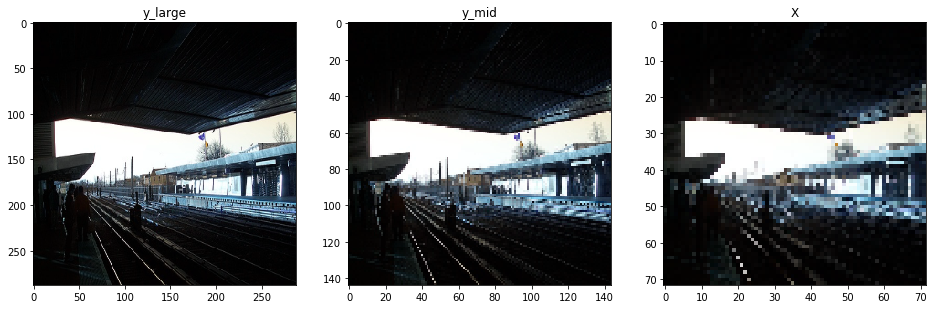

In [7]:
show_images(trainset[50])

In [8]:
class convnet(nn.Module):
    
    def __init__(self):
        super(convnet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample1 = nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1)
#         self.upsample1 = nn.Upsample(scale_factor=2.0, mode='nearest')
        self.conv3 = nn.Conv2d(64, 3, 1)
        
    def forward(self, x):
#         print('input shape: ', x.shape)
        x = self.conv1(x)
#         print('1st layer output shape: ', x.shape)
        x = self.conv2(self.relu(x))
#         print('2nd layer output shape: ', x.shape)
        x = self.upsample1(self.relu(x), output_size=(144, 144))
#         print('Upsample layer output shape: ', x.shape)
        x = self.conv3(self.relu(x))
#         print('final layer output shape: ', x.shape)
        return x

In [9]:
def train_model_y_mid(config, net, train_data, optimizer, loss_fn=None):
    net.train()
    train_loss = 0
    if loss_fn is None:
        loss_fn = nn.MSELoss()
    for i, batch in tqdm(enumerate(train_data), total=len(train_data)):
        X = batch['X']
        y_mid = batch['y_mid']
        optimizer.zero_grad()
        output = net(X)
        loss = loss_fn(output, y_mid)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    wandb.log({'Train Loss - Step 1': train_loss/len(train_data)}, commit=False)

def test_model_y_mid(config, net, test_data, loss_fn=None):
    net.eval()
    test_loss = 0
    example_images = []
    if loss_fn is None:
        loss_fn = nn.MSELoss()
    with torch.no_grad():
        for j, batch in tqdm(enumerate(test_data), total=len(test_data)):
            X = batch['X']
            y_mid = batch['y_mid']
            output = net(X)
            test_loss += loss_fn(output, y_mid).item()
            example_images.append(wandb.Image(transforms.ToPILImage(mode='RGB')(output[0]), 
                                              caption="Output Reconstruction"))
            example_images.append(wandb.Image(transforms.ToPILImage(mode='RGB')(y_mid[0]), 
                                              caption="Target"))
    wandb.log({'Test Loss - Step 1': test_loss/len(test_data), "Examples": example_images})

In [10]:
model = convnet().to(device)
wandb.watch(model, log="all")
optimizer = optim.Adam(model.parameters(), lr=config.lr)
loss_fn = nn.MSELoss()

In [11]:
train_1 = False
if train_1:
    for epoch in range(1, config.epochs + 1):
        train_model_y_mid(config, model, trainloader, optimizer, loss_fn)
        test_model_y_mid(config, model, testloader, loss_fn)

In [12]:
class convnet2(convnet):
    
    def __init__(self):
        super(convnet2, self).__init__()
        self.upsample2 = nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1)
        self.conv3_1 = nn.Conv2d(64, 3, 1)
        self.conv3_2 = nn.Conv2d(64, 3, 1)
    
    def forward(self, x):
        x = self.conv1(x)
#         print('1st layer output shape: ', x.shape)
        x = self.conv2(self.relu(x))
#         print('2nd layer output shape: ', x.shape)
        x = self.upsample1(x, output_size=(144, 144))
#         print('Upsample layer output shape: ', x.shape)
        x = self.relu(x)
        x_mid = self.conv3_1(x)
#         print('final layer x_mid output shape: ', x_mid.shape)
        x_large = self.upsample2(x, output_size=(288, 288))
#         print('final layer x_large output shape: ', x_large.shape)
        x_large = self.conv3_2(self.relu(x_large))
        return x_mid, x_large

In [13]:
def train_model_y_mid_large(config, net, train_data, optimizer, loss_fn=None, step=2):
    net.train()
    train_loss = 0
    if loss_fn is None:
        loss_fn = nn.MSELoss()
    for i, batch in tqdm(enumerate(train_data), total=len(train_data)):
        X = batch['X']
        y_mid = batch['y_mid']
        y_large = batch['y_large']
        optimizer.zero_grad()
        mid_output, large_output = net(X)
        loss = loss_fn(mid_output, y_mid) + loss_fn(large_output, y_large)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    wandb.log({f'Train Loss - Step {step}': train_loss/len(train_data)}, commit=False)

def test_model_y_mid_large(config, net, test_data, loss_fn=None, step=2):
    net.eval()
    test_loss = 0
    example_images = []
    if loss_fn is None:
        loss_fn = nn.MSELoss()
    with torch.no_grad():
        for j, batch in tqdm(enumerate(test_data), total=len(test_data)):
            X = batch['X'].to(device)
            y_mid = batch['y_mid'].to(device)
            y_large = batch['y_large'].to(device)
            mid_output, large_output = net(X)
            test_loss += loss_fn(mid_output, y_mid).item() + loss_fn(large_output, y_large).item()  
            example_images.append(wandb.Image(mid_output[0], caption="Mid Output Reconstruction"))
            example_images.append(wandb.Image(large_output[0], caption="Large Output Reconstruction"))
            example_images.append(wandb.Image(y_mid[0], caption="Target"))
    wandb.log({f'Test Loss - Step {step}': test_loss/len(test_data), "Examples": example_images})

In [14]:
model2 = convnet2().to(device)
wandb.watch(model2, log="all")
optimizer2 = optim.Adam(model2.parameters(), lr=config.lr)
loss_fn = nn.MSELoss()

In [15]:
train_2 = False
if train_2:
    for epoch in range(1, config.epochs + 1):
        train_model_y_mid_large(config, model2, trainloader, optimizer2, loss_fn, step=2)
        test_model_y_mid_large(config, model2, testloader, loss_fn, step=2)

In [21]:
class resnet(nn.Module):
    
    def __init__(self):
        super(resnet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 1)
        self.relu = nn.ReLU()
        self.res_block1_1 = nn.Conv2d(32,32, 3, padding=1)
        self.res_block1_2 = nn.Conv2d(32,32, 3, padding=1)
        self.res_block2_1 = nn.Conv2d(32,32, 3, padding=1)
        self.res_block2_2 = nn.Conv2d(32,32, 3, padding=1)
        self.upsample1 = nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1)
        self.res_block3_1 = nn.Conv2d(32,32, 3, padding=1)
        self.res_block3_2 = nn.Conv2d(32,32, 3, padding=1)
        self.upsample2 = nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1)
        self.conv3_1 = nn.Conv2d(32, 3, 1)
        self.conv3_2 = nn.Conv2d(32, 3, 1)

    def forward(self, x):
#         print('input shape: ', x.shape)
        h, w = x.shape[-2:]
        x = self.conv1(x)
        # print('1st layer output shape: ', x.shape)
        x_res = self.res_block1_1(x)
        x_res = self.res_block1_2(x_res)
        x = self.relu(x + x_res)
        # print('1st residual layer output shape: ', x.shape)
        x_res = self.res_block2_1(x)
        x_res = self.res_block2_2(x_res)
        x = self.relu(x_res + x)
        # print('2nd residual layer output shape: ', x.shape)
        x = self.upsample1(x, output_size=(h*2, w*2))
        h, w = x.shape[-2:]
        # print('1st Upsample layer output shape: ', x.shape)
        x_mid = self.conv3_1(self.relu(x))
        # print('final layer x_mid output shape: ', x_mid.shape)
        x_res = self.res_block3_1(x)
        x_res = self.res_block3_2(x_res)
        x = self.relu(x_res + x)
        x_large = self.upsample2(x, output_size=(h*2, w*2))
        # print('final layer x_large output shape: ', x_large.shape)
        x_large = self.conv3_2(x_large)
        return x_mid, x_large

In [22]:
dataiter = iter(trainloader)
test = next(dataiter)

In [23]:
model3 = resnet().to(device)
wandb.watch(model3, log="all")
optimizer3 = optim.Adam(model3.parameters(), lr=config.lr)
loss_fn = nn.MSELoss()

In [24]:
train_3 = True
if train_3:
    for epoch in range(1, config.epochs + 1):
        train_model_y_mid_large(config, model3, trainloader, optimizer3, loss_fn, step=3)
        test_model_y_mid_large(config, model3, testloader, loss_fn, step=3)

100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


In [26]:
y_mid, y_large = model3(test['X'])

In [32]:
show_images({k: v[0] for k, v in test.items()})

SyntaxError: invalid syntax (<ipython-input-32-1a7a09ae7ae9>, line 1)